
# Plot Metrics from `results/generated_*`

This notebook scans folders like `results/generated_5`, `results/generated_10`, ..., `results/generated_60`,
reads each `metrics.csv` (columns: `total_waiting_time,total_energy_waste`), and produces **two bar charts**:

1. **Energy Waste vs Folder** — y = `total_energy_waste`, x = folder number (5,10,...,60).
2. **Waiting Time vs Folder** — y = `total_waiting_time`, x = folder number (5,10,...,60).

The figures are also saved to `results/plots/`.


In [5]:

import os
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Inline plots
%matplotlib inline


In [6]:

# Change this if needed
results_dir = Path('results')    # directory containing generated_* folders
output_dir  = results_dir / 'plots'
output_dir.mkdir(parents=True, exist_ok=True)
print('Results dir:', results_dir.resolve())
print('Output dir :', output_dir.resolve())


Results dir: /Users/alfaa/Arsitektur UGM/SPARS-AIBT-2025/results
Output dir : /Users/alfaa/Arsitektur UGM/SPARS-AIBT-2025/results/plots


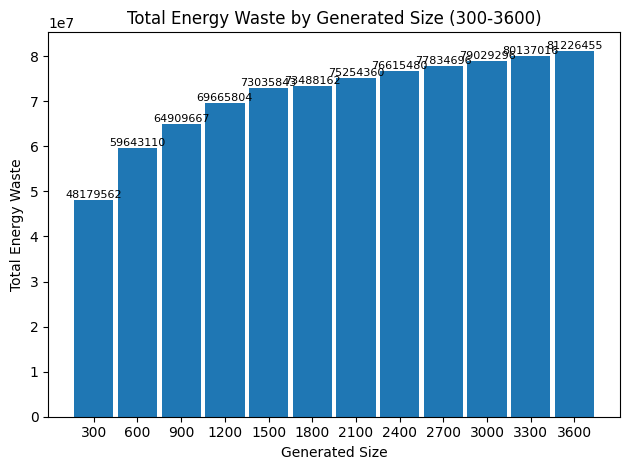

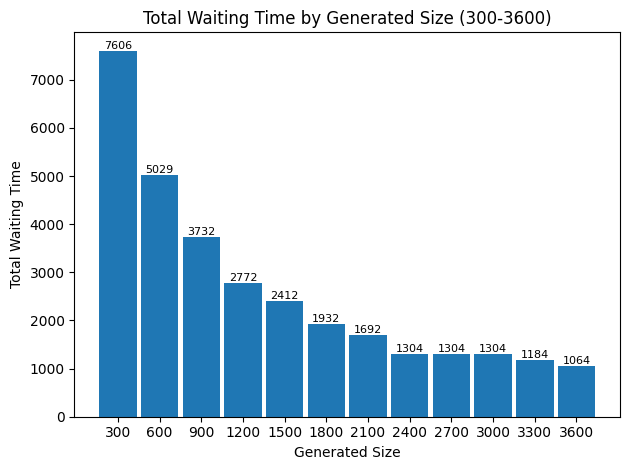

In [7]:
def collect_metrics(results_dir: Path):
    """
    Collects metrics from generated_ folders within a specific range.
    """
    # The new pattern matches numbers from 300 to 3600.
    pat = re.compile(r'^generated_(300|600|900|1200|1500|1800|2100|2400|2700|3000|3300|3600)$')
    rows = []
    
    for entry in results_dir.iterdir():
        if not entry.is_dir():
            continue
        
        m = pat.match(entry.name)
        if not m:
            continue
        
        # Get the number from the folder name
        k = int(m.group(1))
        
        csv_path = entry / 'metrics.csv'
        if not csv_path.is_file():
            continue
        
        try:
            df = pd.read_csv(csv_path)
        except Exception as e:
            print(f"[WARN] Failed to read {csv_path}: {e}")
            continue
            
        cols = [c.lower().strip() for c in df.columns.tolist()]
        
        # The existing logic to get values remains the same
        if 'total_waiting_time' in cols and 'total_energy_waste' in cols:
            tw = float(df['total_waiting_time'].iloc[0])
            te = float(df['total_energy_waste'].iloc[0])
        else:
            try:
                tw = float(df.iloc[0, 0])
                te = float(df.iloc[0, 1])
            except Exception as e:
                print(f"[WARN] Bad format in {csv_path}: {e}")
                continue
                
        rows.append((k, te, tw))
        
    rows.sort(key=lambda x: x[0])
    return rows

def plot_bars(xs, ys, xlabel, ylabel, title, out_path):
    """
    Plots a bar chart with the given data and saves it to a file.
    """
    idx = np.arange(len(xs))
    fig, ax = plt.subplots()
    bars = ax.bar(idx, ys, width=0.9)

    ax.set_xticks(idx, [str(x) for x in xs])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    if all(float(y).is_integer() for y in ys):
        fmt = '%d'
    else:
        fmt = '%.2f'

    for rect, y in zip(bars, ys):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, height,
                fmt % y,
                ha='center', va='bottom', fontsize=8, rotation=0)

    fig.tight_layout()
    fig.savefig(out_path, dpi=150)
    plt.show()

# Example usage
if __name__ == '__main__':
    # Adjust this path to your actual results folder.
    results_dir = Path("results")
    
    # Collect metrics for the specified range
    metrics = collect_metrics(results_dir)
    
    # Separate the data for plotting
    xs = [row[0] for row in metrics]  # The number from the folder name
    ys_te = [row[1] for row in metrics] # Total energy waste
    ys_tw = [row[2] for row in metrics] # Total waiting time
    
    # Plotting Total Energy Waste
    plot_bars(
        xs, 
        ys_te, 
        xlabel="Generated Size", 
        ylabel="Total Energy Waste", 
        title="Total Energy Waste by Generated Size (300-3600)", 
        out_path="total_energy_waste.png"
    )

    # Plotting Total Waiting Time
    plot_bars(
        xs, 
        ys_tw, 
        xlabel="Generated Size", 
        ylabel="Total Waiting Time", 
        title="Total Waiting Time by Generated Size (300-3600)", 
        out_path="total_waiting_time.png"
    )

,folder,total_energy_waste,total_waiting_time
0,300,48179562.0,38.030
1,600,59643110.0,25.145
2,900,64909667.0,18.660
3,1200,69665804.0,13.860
4,1500,73035843.0,12.060
5,1800,73488162.0,9.660
6,2100,75254360.0,8.460
7,2400,76615480.0,6.520
8,2700,77834696.0,6.520
9,3000,79029296.0,6.520


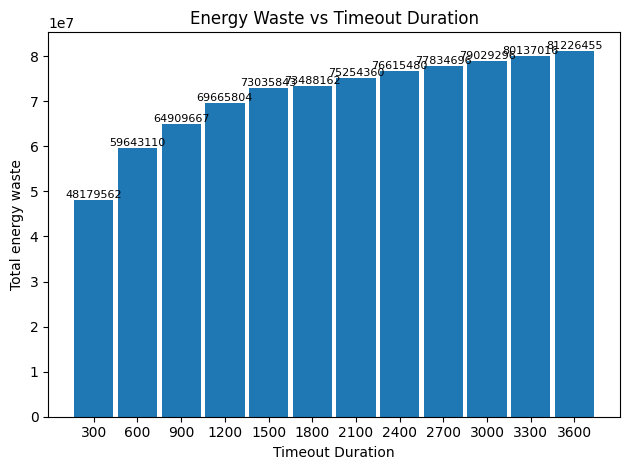

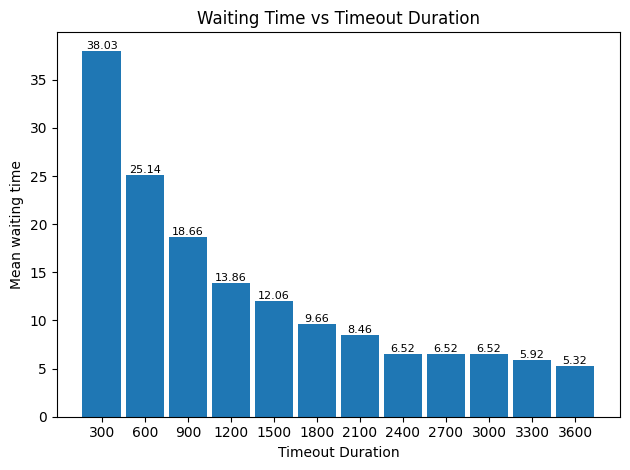

Saved: results/plots/summary.csv
Saved: results/plots/energy_waste_bar.png
Saved: results/plots/waiting_time_bar.png


In [8]:

rows = collect_metrics(results_dir)
if not rows:
    raise SystemExit(f"No metrics found under {results_dir}/generated_*/metrics.csv")

xs  = [r[0] for r in rows]
tew = [r[1] for r in rows]  # total_energy_waste
twt = [r[2] for r in rows]  # total_waiting_time
twt = (np.array(twt) / 200).tolist()

# Save a summary table (optional)
summary = pd.DataFrame({'folder': xs, 'total_energy_waste': tew, 'total_waiting_time': twt})
summary_path = output_dir / 'summary.csv'
summary.to_csv(summary_path, index=False)
display(summary)

# Plot 1: Energy waste bars
plot_bars(xs, tew, 'Timeout Duration', 'Total energy waste',
          'Energy Waste vs Timeout Duration', output_dir / 'energy_waste_bar.png')

# Plot 2: Waiting time bars
plot_bars(xs, twt, 'Timeout Duration', 'Mean waiting time',
          'Waiting Time vs Timeout Duration', output_dir / 'waiting_time_bar.png')

print("Saved:", summary_path)
print("Saved:", output_dir / 'energy_waste_bar.png')
print("Saved:", output_dir / 'waiting_time_bar.png')
